In [1]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 1271-A82D

 Directory of C:\Users\FREEDMAN_LAB\Documents\StephT\two_boundary_DMC\MT_analysis

01/29/2020  12:17 PM    <DIR>          .
01/29/2020  12:17 PM    <DIR>          ..
01/29/2020  12:13 PM    <DIR>          .ipynb_checkpoints
01/29/2020  12:17 PM            16,698 category_decoder.ipynb
01/29/2020  11:51 AM        85,324,444 neville_20191004_1_merged_w_ratings.mat
01/29/2020  11:53 AM        85,313,586 neville_20191007_2_merged_w_ratings.mat
01/29/2020  11:53 AM        77,382,867 neville_20191015_2_merged_w_ratings.mat
01/29/2020  11:53 AM        63,517,755 neville_20191018_1_merged_w_ratings.mat
01/29/2020  11:53 AM        77,631,602 neville_20191028_1_merged_w_ratings.mat
01/29/2020  11:53 AM        60,659,697 neville_20191030_1_merged_w_ratings.mat
01/29/2020  11:53 AM        90,833,295 neville_20191031_1_merged_w_ratings.mat
01/29/2020  11:53 AM        65,346,895 neville_20191101_1_merged_w_ratings.mat
01/29/2020  1

In [2]:
import os
import glob
import scipy.io as sio
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
np.set_printoptions(threshold=4000, precision=4) 

#make test and train sets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # "Support Vector Classifier" 

## Decoder

In [11]:
data_all = []

fns = glob.glob("neville_*_merged_w_ratings.mat")
for fn in fns:

    # Load the file specified by fn
    data        = sio.loadmat(fn)['data']

    # Split up neuronal/behavioral
    bhv   = data['BHV']
    neuro = data['NEURO']

    # Extract relevant behavioral variables for all the trials
    error     = bhv[0][0][0][0]["TrialError"]
    trial_num = len(bhv[0][0][0][0]["TrialNumber"][0])
    condition = bhv[0][0][0][0]["ConditionNumber"][0]

    # Do the same for neural data
    num_neurons = len(neuro[0][0][0][0]["Neuron"][0][0])//2
    spikes_all  = neuro[0][0][0][0]["Neuron"][0][0]
    code_time   = neuro[0][0][0][0]['CodeTimes']
    code_num    = neuro[0][0][0][0]['CodeNumbers']
    code_num    = np.array([i[0] for i in code_num]) 

    dirs         = [247.5, 225, 202.5, 67.5, 45, 22.5, 157.5, 135, 112.5, 337.5, 315, 292.5]
    STRT_TRIAL   = 9
    STIM_ON      = 23

    strt_trial_indx = np.where(code_num == STRT_TRIAL)[0]
    strt_trial_time = code_time[strt_trial_indx]
    spk_window      = np.arange(-500, 3000) 


    # Correct trial IDs
    correct_inds   = set(np.where(error == 0)[0])
    condition_inds = set(np.where(condition != 73)[0])
    trial_inds     = correct_inds.intersection(condition_inds)

    #set up bins for all neuronal data


    # Loop through neurons
    for i_neuron in range(num_neurons):
    # Set up storage for spikes by direction
        spikes_binned = [[] for i in range(len(dirs))]
    # Extract neural data for this neuron across trials
        rating        = neuro[0][0][0][0][-1][i_neuron][1][0][0]
        neuron_spikes = spikes_all[i_neuron].flatten() 

        if rating >= 3:
        # Loop through trials
            for i_trial in trial_inds:
                if code_num[strt_trial_indx[i_trial]+1] != 14:
                    end_indx = min(i_trial + 1, trial_num) 
            # Compute when the stimulus for this trial came on
                    stim_on_indx = np.where(code_num[strt_trial_indx[i_trial]:strt_trial_indx[end_indx]] == STIM_ON)[0]
                    stim_on_indx = stim_on_indx + strt_trial_indx[i_trial]
            # Find spike times for this trial based on stim. on index, compute histogram
                    stim_on_time = code_time[stim_on_indx].flatten()[0]
                    spks         = neuron_spikes[(neuron_spikes - stim_on_time > -500) & 
                                                 (neuron_spikes - stim_on_time < 3000)] - stim_on_time       
                    hist_spks    = np.histogram(spks, spk_window)[0]
            #smooth hist
                    smoothed = np.convolve(hist_spks,np.ones(100), mode = 'valid')
                    smoothed = smoothed.astype(int)
            # Store the smoothed hist for this trial
                    dir_num = int(np.ceil(condition[i_trial]/6)) - 1
                    spikes_binned[dir_num].append(smoothed)
                    spikes_binned = np.array(spikes_binned)
     #worried that this only stores neurons from one data set        
            data_all.append(spikes_binned)

        

In [10]:
qdrt_1 = [np.vstack(d[3:6]) for d in data_all]
qdrt_2 = [np.vstack(d[6:9]) for d in data_all]
qdrt_3 = [np.vstack(d[0:3]) for d in data_all]
qdrt_4 = [np.vstack(d[9:12]) for d in data_all]


In [6]:
#params
n_trials = 40
num_good_neurons = len(data_all)
time_pts = np.arange(0, (len(spk_window)-100),10)
iterations = 100
iterative_accuracy = np.zeros((iterations, len(time_pts)))

#set category labels
y = np.zeros((n_trials*2,))
for i in range(n_trials*2):
    if i <=40:
        y[i] = 1
    if i > 40:
        y[i] = 2
    y = y.astype(int)

for iteration in range(iterations):

    #iterate thru trial timepoints
    for indx, time_pt in enumerate(time_pts):

        #rndm_indices_qdrt_all = np.zeros((8, num_good_neurons, n_trials))
        rndm_indices_qdrt1 = np.zeros((num_good_neurons, n_trials))
        rndm_indices_qdrt2 = np.zeros((num_good_neurons, n_trials))
        rndm_indices_qdrt3 = np.zeros((num_good_neurons, n_trials))
        rndm_indices_qdrt4 = np.zeros((num_good_neurons, n_trials))

        selected_timept_qdrt1 = np.zeros((num_good_neurons, n_trials))
        selected_timept_qdrt2 = np.zeros((num_good_neurons, n_trials))
        selected_timept_qdrt3 = np.zeros((num_good_neurons, n_trials))
        selected_timept_qdrt4 = np.zeros((num_good_neurons, n_trials))




        #Get random trials
        for i_neuron in range(len(data_all)):
            rng1 = (len(qdrt_1[i_neuron]))
            rndm_indices_qdrt1[i_neuron] = (np.random.choice(rng1, size = n_trials, replace = False))
            rndm_indices_qdrt1 = rndm_indices_qdrt1.astype(np.int32)

            rng2 = (len(qdrt_2[i_neuron]))
            rndm_indices_qdrt2[i_neuron] = (np.random.choice(rng2, size = n_trials, replace = False))
            rndm_indices_qdrt2 = rndm_indices_qdrt2.astype(np.int32)

            rng3 = (len(qdrt_3[i_neuron]))
            rndm_indices_qdrt3[i_neuron] = (np.random.choice(rng3, size = n_trials, replace = False))
            rndm_indices_qdrt3 = rndm_indices_qdrt3.astype(np.int32)
            rng4 = (len(qdrt_4[i_neuron]))
            rndm_indices_qdrt4[i_neuron] = (np.random.choice(rng4, size = n_trials, replace = False))
            rndm_indices_qdrt4 = rndm_indices_qdrt4.astype(np.int32)
            #get timept value
            for  i_trial in range(len(rndm_indices_qdrt1[i_neuron])):
                value1 = rndm_indices_qdrt1[i_neuron][i_trial]
                selected_timept_qdrt1[i_neuron][i_trial] = qdrt_1[i_neuron][value1][time_pt]
            selected_timept_qdrt1 = selected_timept_qdrt1.astype(np.int32)
            for  i_trial in range(len(rndm_indices_qdrt2[i_neuron])):
                value2 = rndm_indices_qdrt2[i_neuron][i_trial]
                selected_timept_qdrt2[i_neuron][i_trial] = qdrt_2[i_neuron][value2][time_pt]
            selected_timept_qdrt2 = selected_timept_qdrt2.astype(np.int32)
            for  i_trial in range(len(rndm_indices_qdrt3[i_neuron])):
                value3 = rndm_indices_qdrt3[i_neuron][i_trial]
                selected_timept_qdrt3[i_neuron][i_trial] = qdrt_3[i_neuron][value3][time_pt]
            selected_timept_qdrt3 = selected_timept_qdrt3.astype(np.int32)
            for  i_trial in range(len(rndm_indices_qdrt4[i_neuron])):
                value4 = rndm_indices_qdrt4[i_neuron][i_trial]
                selected_timept_qdrt4[i_neuron][i_trial] = qdrt_4[i_neuron][value4][time_pt]
            selected_timept_qdrt4 = selected_timept_qdrt4.astype(np.int32)

    #set up training and test sets
        train_quadrants = [np.vstack((selected_timept_qdrt1.T, selected_timept_qdrt2.T)), 
                          np.vstack((selected_timept_qdrt2.T, selected_timept_qdrt3.T)),
                          np.vstack((selected_timept_qdrt3.T, selected_timept_qdrt4.T)),
                          np.vstack((selected_timept_qdrt4.T, selected_timept_qdrt1.T))]

        test_quadrants = [np.vstack((selected_timept_qdrt3.T, selected_timept_qdrt4.T)), 
                          np.vstack((selected_timept_qdrt4.T, selected_timept_qdrt1.T)),
                          np.vstack((selected_timept_qdrt1.T, selected_timept_qdrt2.T)),
                          np.vstack((selected_timept_qdrt2.T, selected_timept_qdrt3.T))]

        #choose test/train sets randomly 
        qdrts = np.arange(0,4)
        rand_qdrts = np.random.choice(qdrts, size = 1)


    #run decoder
        x_train = []
        x_test = []
        for i in rand_qdrts:
            x_train = train_quadrants[i]
            x_test = test_quadrants[i]
            clf = SVC(kernel='linear') # intialize classifier
            clf.fit(x_train,y)
            pred = clf.predict(x_test)

        iterative_accuracy[iteration][indx] = sum(pred==y)/len(y)*100





In [7]:
iterative_accuracy.shape

(100, 340)

In [8]:
#save output array as CSV
#sio.savemat("MT_decoder.mat", {'iterative_accuracy': iterative_accuracy} )

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Time (ms)'),
 Text(0.5, 1.0, 'MT Category decoder')]

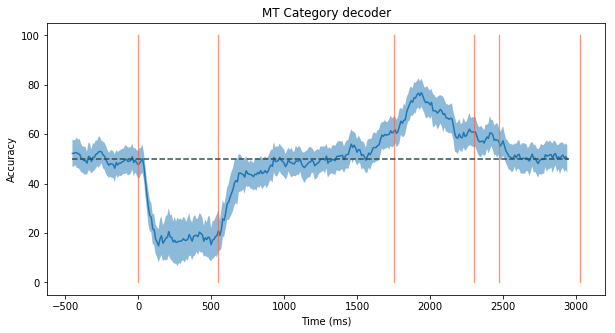

In [9]:
#Decoder accuracy plot
mean_accuracy = np.mean(iterative_accuracy, axis = 0)
sd_accuracy = np.std(iterative_accuracy, axis = 0)
x = np.arange(-450,2950,10)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(x, mean_accuracy)


#Std shading 
ax.fill_between(x, mean_accuracy-sd_accuracy, mean_accuracy+sd_accuracy, alpha = 0.5)

#trial epoch lines 
SAMPLE = 550
DELAY1 = 1200 + SAMPLE
TEST1  = 550 + DELAY1
DELAY2 = 175 + TEST1
TEST2  = 550 + DELAY2    
trial_epochs = [SAMPLE, DELAY1, TEST1, DELAY2, TEST2]
ax.plot([0, 0], [0, 100], '-k', lw = 1.3, color = 'tomato', alpha = .7)
for epoch in trial_epochs:
    ax.plot([epoch, epoch], [0, 100], '-k', lw = 1.3, color = 'tomato', alpha = .7)
    #ax.set.xticks()

#50% line 
ax.plot([-450, 2950], [50, 50], '--k', color = 'darkslategrey')

#labels, etc
ax.set(xlabel='Time (ms)', 
       ylabel='Accuracy', 
       title='MT Category decoder')
